# Bayesian sampling of the posterior distribution

## Part 1: simple model (Gaussian)

The posterior distribution is defined over the set of structural ensembles with the same functional form as the optimal solution of Ensemble Refinement, parametrized by $\vec\lambda$. Alternatively, you could also have a set of structural ensembles given by some free/flexible coefficients of a force-field correction, or the most general variational freedom of ensembles defined over an arbitrary number of frames.

The posterior distribution is given by the exponential of minus the loss function.

In [1]:
import os, pandas
import numpy as np
import matplotlib, matplotlib.pyplot as plt

In [2]:
from Functions.basic_functions_bayesian import compute, compute_single, run_Metropolis

In [3]:
dir_name = 'Manuscript_images'

if not os.path.exists(dir_name):
    os.mkdir(dir_name)

### Define `simple_model` with a quadratic potential

In [4]:
seed = 1
rng = np.random.default_rng(seed)

In [5]:
n_frames = int(1e4)

# p0 = np.random.dirichlet(np.ones(n_frames), size=None)
p0 = np.ones(n_frames)/n_frames
sigma = 0.5

x = rng.normal(0, scale=sigma, size=n_frames)

x_exp = 1.7  # 0.3
sigma_exp = 0.6  # 0.02

alpha = 0.5

In [6]:
class Simple_model():
    def __init__(self, n_frames, sigma, x_exp, sigma_exp, alpha, seed : int=1):

        rng = np.random.default_rng(seed)

        self.n_frames = n_frames
        self.p0 = np.ones(n_frames)/n_frames
        self.sigma = sigma
        self.x = rng.normal(0, scale=sigma, size=n_frames)
        self.x_exp = x_exp
        self.sigma_exp = sigma_exp
        self.alpha = alpha

simple_model = Simple_model(n_frames, sigma, x_exp, sigma_exp, alpha)

(-2.129877624926896, 2.510946553567947)


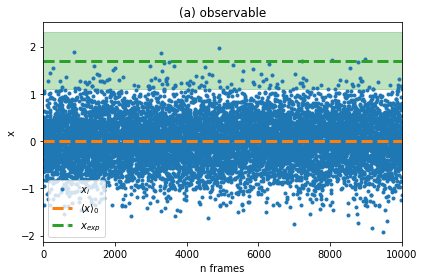

In [7]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['font.size'] = 15
plt.rcParams.update({'figure.autolayout': True})

plt.figure(figsize=(6, 4))
plt.plot(x, '.', label=r'$x_i$')

plt.plot([-5, len(x) + 5], [np.mean(x), np.mean(x)], '--', label=r'$\langle x\rangle_0$')  # ,color='tab:blue')

plt.plot([-5, len(x) + 5], [x_exp, x_exp], '--', label=r'$x_{exp}$')
plt.fill_between([-5, len(x) + 5], [x_exp - sigma_exp, x_exp - sigma_exp], [x_exp + sigma_exp, x_exp + sigma_exp], alpha=0.3, color='tab:green')

plt.title('(a) observable')
plt.legend(loc='lower left')
plt.xlim([-5, len(x) + 5])
plt.ylabel('x')
plt.xlabel('n frames')

print(plt.ylim())
# plt.ylim([-2.3, 2.5])

# plt.savefig('Manuscript_images/ex1_obs.pdf', format='pdf', bbox_inches='tight')

### Compute properties of discrete case and compare with continuous analogue

in the continuous case (no discrete frames), there is not a pleateau value of the loss function

In [8]:
class Continuous_analogue():
    """ Continuous case of a quadratic potential with tuning elastic strength 1/sigma**2 
        and soft restraint on the average position (not on its variance -- you could implement also this case)
    """
    def __init__(self, lambdas, sigma, x_exp, sigma_exp):
        self.logZ = 1/2*(lambdas*sigma)**2
        self.av_x = -lambdas*sigma**2
        self.dkl = self.logZ
        self.jeffreys = sigma
        self.gamma = 1/2*(lambdas*sigma)**2 + lambdas*x_exp
        self.loss = 1/2*((lambdas*sigma**2 + x_exp)/sigma_exp)**2 + 1/2*alpha*(lambdas*sigma)**2


In [9]:
dlambda = 1e-1
lambdamax = 100
lambdas = np.arange(-lambdamax-dlambda, lambdamax+dlambda, dlambda)

In [10]:
continuous_case = Continuous_analogue(lambdas, sigma, x_exp, sigma_exp)

In [11]:
results = compute(lambdas, p0, x, x_exp, sigma_exp, alpha)

results.keys()

dict_keys(['P', 'Z', 'av_g', 'av_g2', 'var_g', 'std_g', 'chi2', 'Srel', 'lossf', 'gamma', 'jeffreys', 'cov', 'dirichlet', 'avg_density'])

In [12]:
dV = results['lossf'][0] - np.min(results['lossf'])
print('depth: ', dV)

depth:  3.03040153508974


-7.700000000005247


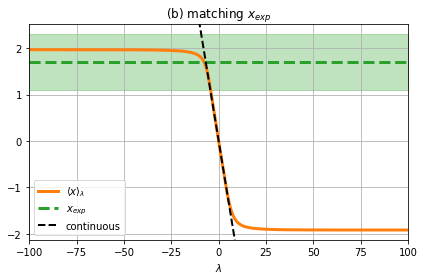

In [13]:
plt.figure(figsize=(6, 4))
plt.plot(lambdas, results['av_g'], '-', label=r'$\langle x \rangle_\lambda$', c='tab:orange')
plt.plot([lambdas[0], lambdas[-1]], [x_exp, x_exp], '--', label='$x_{exp}$', c='tab:green')
plt.fill_between([lambdas[0], lambdas[-1]], [x_exp - sigma_exp, x_exp - sigma_exp], [x_exp + sigma_exp, x_exp + sigma_exp], alpha=0.3, color='tab:green')
#plt.yscale('log')
plt.xlabel('$\lambda$')
plt.xlim([np.min(lambdas), np.max(lambdas)])
plt.title('(b) matching $x_{exp}$')

ylims = plt.ylim()

plt.plot(lambdas, continuous_case.av_x, 'k--', label='continuous', linewidth=2)
plt.legend()
plt.grid()

plt.ylim(ylims)
# plt.ylim([-2.3, 2.5])

print(lambdas[np.argmin(np.abs(results['av_g'] - x_exp))])

# plt.savefig('Manuscript_images/b_ex1_g_match_2.pdf', format='pdf', bbox_inches='tight')

#### plot comparison with continuous analogue

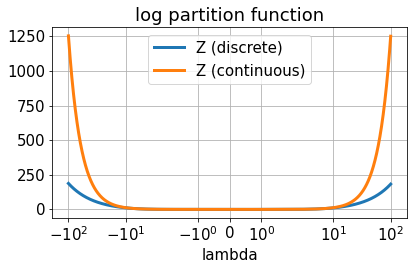

In [14]:
plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 3

plt.plot(lambdas, np.log(results['Z']), '-', label='Z (discrete)')
plt.plot(lambdas, 1/2*(lambdas*sigma)**2, label='Z (continuous)')
# plt.yscale('symlog')
plt.xscale('symlog')
plt.xlabel('lambda')
plt.title('log partition function')
plt.legend()
plt.grid()



-1.6720810608534458


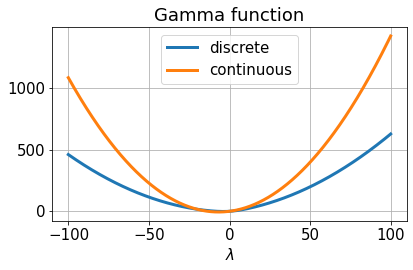

In [15]:
plt.title('Gamma function')
plt.plot(lambdas, results['gamma'], label='discrete')
plt.plot(lambdas, 1/2*(lambdas*sigma)**2 + lambdas*x_exp, label='continuous')
plt.grid()
plt.legend()
plt.xlabel('$\lambda$')

print(np.min(results['gamma']))

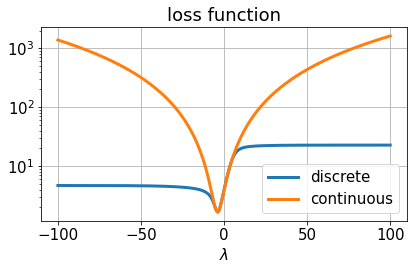

In [16]:
plt.title('loss function')
plt.plot(lambdas, results['lossf'], label='discrete')
plt.plot(lambdas, continuous_case.loss, label='continuous')
plt.xlabel('$\lambda$')
plt.legend()
plt.grid()
plt.yscale('log')

-3.9000000000054627


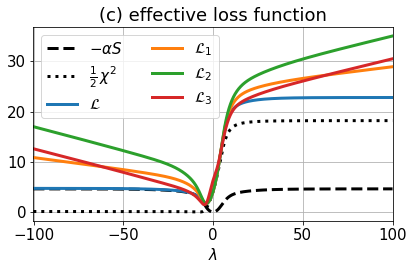

In [17]:
plt.figure(figsize=(6, 4))

# plt.plot(lambdas, loss)

plt.plot(lambdas, -alpha*results['Srel'], 'k--', label=r'$- \alpha S$')  # _{rel}$')
plt.plot(lambdas, 1/2*results['chi2'], 'k:', label=r'$\frac{1}{2} \, \chi^2$')
# plt.plot(lambdas, -alpha*results['Srel'] + 1/2*results['chi2'][:, 0], '-', label=r'$\mathcal{L}=\chi^2/\,2 - \alpha S_{rel}$')
plt.plot(lambdas, results['lossf'], label=r'$\mathcal{L}$')  # =\chi^2/\,2 - \alpha S_{rel}$')

wh = np.argmin(results['lossf'])

jeff0 = np.log(results['jeffreys'][wh])
plt.plot(lambdas, results['lossf'] - np.log(results['jeffreys']) + jeff0, label=r'$\mathcal{L}_1$')  #  - \log\sigma$')

var0 = np.log(results['var_g'][wh])
plt.plot(lambdas, results['lossf'] - np.log(results['var_g']) + var0, label=r'$\mathcal{L}_2$')  #  - \log\sigma^2$')

dirich0 = np.log(results['dirichlet'][wh])
plt.plot(lambdas, results['lossf'] - np.log(results['dirichlet']) + dirich0, label=r'$\mathcal{L}_3$')  #  - Dirichlet$')

plt.title(r'(c) effective loss function')
# plt.yscale('log')
# plt.xlim([-50, 50])
plt.xlabel(r'$\lambda$')
plt.legend(ncol=2)
plt.grid()
plt.xlim([lambdas[0], lambdas[-1]])
# plt.yscale('symlog')
# plt.xscale('symlog')

# plt.savefig('Manuscript_images/b_ex1_loss_adj.pdf', format='pdf', bbox_inches='tight')

print(lambdas[np.argmin(results['lossf'])])

In [18]:
hyper_P0 = np.exp(-results['lossf'])
hyper_P_gamma = np.exp(-results['gamma'])
hyper_P_jef = np.exp(-results['lossf'])*results['jeffreys']/results['jeffreys'][wh]
hyper_P_belt = np.exp(-results['lossf'])*results['var_g']/results['var_g'][wh]
hyper_P_dir = np.exp(-results['lossf'])*results['dirichlet']/results['dirichlet'][wh]

In [19]:
def plot_with_interrumpted_x_axis(ns, x, ys, labels, colors=None, lines=None, d : float=.015,
        delta : float=0.2, figsize : tuple=(6, 4)):
    """
    Plot `y` vs. `x` values `for y in ys` with interrumption of x axis beyond `ns[0]` and `ns[1]`
    and stop x axis at `ns[2]`.
    The variable `ns` is either a list/array of float values (in this case the indices are got by
    `np.argmin`) or integer values (in this case they are exactly the indices of `x`) corresponding to
    breaking x axis.
    """

    # if single array/list of values to plot
    try: len(ys[0])
    except: ys = [ys]

    for i in range(3):
        if type(ns[i]) is float:
            ns[i] = np.argmin(np.abs(x - ns[i]))
    
    # specify color and line
    assert (colors is None) or len(colors) == len(ys), 'error in length colors'
    assert (lines is None) or len(lines) == len(ys), 'error in length lines'
    if colors is None : colors = ['']*len(ys)
    if lines is None : lines = ['']*len(ys)

    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=figsize, gridspec_kw={'wspace': 0.05,
        'width_ratios': [1, 1]})  # , dpi=300)  # , 'height_ratios': [1, 1]})

    for i, y in enumerate(ys):
        ax1.plot(x[:ns[0]], y[:ns[0]], color=colors[i], linestyle=lines[i], label=labels[i])
        ax1.set_xlim([x[0], x[ns[0]]])

        ax2.plot(x[ns[1]:ns[2]], y[ns[1]:ns[2]], color=colors[i], linestyle=lines[i])
        ax2.set_xlim([x[ns[1]], x[ns[2]]])

    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.tick_params(axis='y', left=False)

    # add a diagonal break marker
    delta = 1.
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((delta - d, delta + d), (-d, +d), **kwargs)
    ax1.plot((delta - d, delta + d), (delta - d, delta + d), **kwargs)
    kwargs.update(transform=ax2.transAxes)
    ax2.plot((-d, +d), (-d, +d), **kwargs)
    ax2.plot((-d, +d), (delta - d, delta + d), **kwargs)

    ax2.yaxis.set_tick_params(labelleft=False)

    ax1.grid()
    ax2.grid()

    plt.tight_layout()

    # plt.suptitle('(d) non-normalized posterior density')

    # for the legend:
    # handles, labels = ax1.get_legend_handles_labels()
    # fig.legend(handles, labels, loc='upper center')
    
    return fig, ax1, ax2

/tmp/ipykernel_11691/2310375359.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Text(0.5, 0.0, '$\\lambda$')

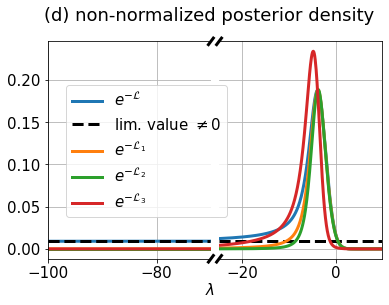

In [20]:
val = np.exp(-results['lossf'][0])

ys = [hyper_P0, val*np.ones(len(lambdas)), hyper_P_jef, hyper_P_belt, hyper_P_dir]
labels = [r'$e^{-\mathcal{L}}$', r'lim. value $\neq 0$'] + [r'$e^{-\mathcal{L}_%i}$' % (i + 1) for i in range(3)]
colors = ['tab:blue', 'k', 'tab:orange', 'tab:green', 'tab:red']
lines = ['-', '--'] + ['-']*3
ns = [-70., -25., 10.]

fig, ax1, ax2 = plot_with_interrumpted_x_axis(ns, lambdas, ys, labels, colors=colors, lines=lines)

# plt.fill_between(lambdas, np.zeros(len(lambdas)), hyper_P0, alpha=0.5)
# ax1.fill_between(lambdas, np.zeros(len(lambdas)), hyper_P0, alpha=0.5)
plt.suptitle('(d) non-normalized posterior density', y=1.0)

handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.15, 0.5))
# plt.legend(loc='upper left')  # (loc='center left', bbox_to_anchor=(1, 0.5))
fig.text(0.5, 0.0, '$\lambda$', ha='center')

# fig.savefig('Manuscript_images/b_ex1_non-norm_loss_break.pdf', format='pdf', bbox_inches='tight')


Text(0.5, 0, '$\\lambda$')

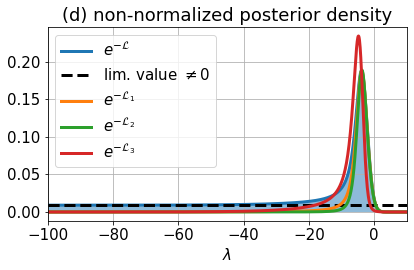

In [21]:
plt.figure(figsize=(6, 4))
plt.plot(lambdas, hyper_P0, label=r'$e^{-\mathcal{L}}$')
plt.fill_between(lambdas, np.zeros(len(lambdas)), hyper_P0, alpha=0.5)

val = np.exp(-results['lossf'][0])
# lim_x = [-40, 10]
lim_x = [lambdas[0], 10]  # or [lambdas[0], lambdas[-1]]

plt.plot(lim_x, [val, val], 'k--', label=r'lim. value $\neq 0$')

for i, hyper_P in enumerate([hyper_P_jef, hyper_P_belt, hyper_P_dir]):
    plt.plot(lambdas, hyper_P, label=r'$e^{-\mathcal{L}_%i}$' % (i + 1))  #  \, \sigma$')
#     # plt.fill_between(lambdas, np.zeros(len(lambdas)), hyper_P, alpha=0.5)

plt.grid()
plt.title('(d) non-normalized posterior density')
plt.legend(loc='upper left')  # (loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(lim_x)
plt.xlabel('$\lambda$')

# plt.savefig('Manuscript_images/b_ex1_non-norm_loss.pdf', format='pdf', bbox_inches='tight')

Text(0.5, 1.0, '(d) ensemble n. density')

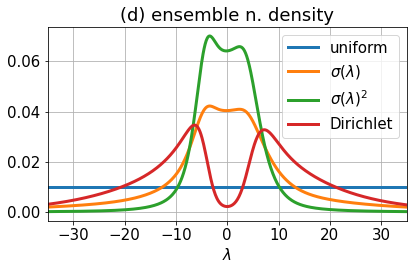

In [22]:
plt.rcParams['font.size'] = 15
plt.rcParams['lines.linewidth'] = 3

normalize = lambda x, dlambda : x/(np.nansum(x)*dlambda)

plt.plot(lambdas, 0.01*np.ones(len(lambdas)), label='uniform')
plt.plot(lambdas, normalize(results['std_g'], dlambda), '-', label=r'$\sigma(\lambda)$')
plt.plot(lambdas, normalize(results['var_g'], dlambda), '-', label=r'$\sigma(\lambda)^2$')
plt.plot(lambdas, normalize(results['dirichlet'], dlambda), '-', label='Dirichlet')


plt.xlabel(r'$\lambda$')
plt.grid()
plt.legend()
plt.xlim([-35, 35])
plt.title('(d) ensemble n. density')  #  (normalized)')

# plt.savefig('Manuscript_images/b_ex1_ensemble_density.pdf', format='pdf', bbox_inches='tight')

### Different n. of frames

In [23]:
dlambda = 5e-1
lambdamax = 100
lambdas = np.arange(-lambdamax-dlambda, lambdamax+dlambda, dlambda)


In [24]:
n_frames = [int(1e3), int(1e4), int(1e5), int(2e5)]

results = {}

for n in n_frames:
    p0 = np.ones(n)/n
    x = rng.normal(0, 0.5, size=n)
    results[n] = compute(lambdas, p0, x, x_exp, sigma_exp, alpha)

In [25]:
my_dict = {}

for n in n_frames:
    my_dict[n] = {
        'std_g' : normalize(results[n]['std_g'], dlambda),
        'var_g' : normalize(results[n]['std_g']**2, dlambda),
        'dirichlet' : normalize(results[n]['dirichlet'], dlambda)}

my_dict

{1000: {'std_g': array([1.10394351e-08, 1.14409996e-08, 1.18289397e-08, 1.30965459e-08,
         1.40926059e-08, 1.53202779e-08, 1.63189036e-08, 1.76477570e-08,
         1.87634317e-08, 2.03778745e-08, 2.20788703e-08, 2.36578794e-08,
         2.54058067e-08, 2.74551111e-08, 2.95914220e-08, 3.17261521e-08,
         3.41251700e-08, 3.68593963e-08, 3.96327851e-08, 4.27555485e-08,
         4.59608336e-08, 4.94611960e-08, 5.32408269e-08, 5.73232308e-08,
         6.16848847e-08, 6.65425553e-08, 7.15437166e-08, 7.71006178e-08,
         8.30203364e-08, 8.93570632e-08, 9.62161113e-08, 1.03580872e-07,
         1.11614216e-07, 1.20125799e-07, 1.29370374e-07, 1.39283020e-07,
         1.49941980e-07, 1.61493014e-07, 1.73875160e-07, 1.87249031e-07,
         2.01573982e-07, 2.17088100e-07, 2.33728400e-07, 2.51675090e-07,
         2.70993421e-07, 2.91797700e-07, 3.14180649e-07, 3.38269248e-07,
         3.64239405e-07, 3.92217987e-07, 4.22297475e-07, 4.54716147e-07,
         4.89622422e-07, 5.27198582e

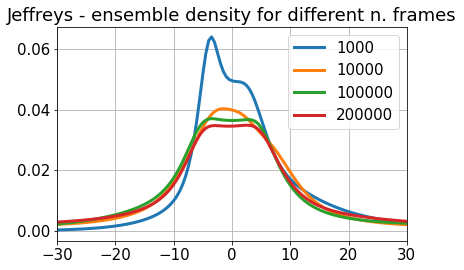

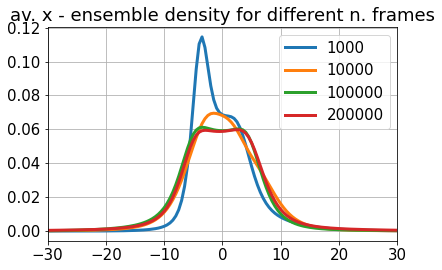

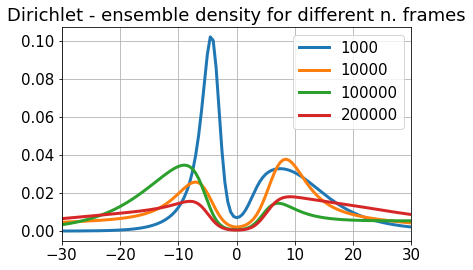

In [26]:
# 1st figure
plt.figure()
plt.title('Jeffreys - ensemble density for different n. frames')

for n in n_frames:
    plt.plot(lambdas, normalize(results[n]['std_g'], dlambda), '-', label=n)  # , c='tab:blue')

plt.legend()
plt.xlim([-30, 30])
plt.grid()

# 2nd figure
plt.figure()
plt.title('av. x - ensemble density for different n. frames')

for n in n_frames:
    plt.plot(lambdas, normalize(results[n]['std_g']**2, dlambda), '-', label=n)  # c='tab:orange'

plt.legend()
plt.xlim([-30, 30])
plt.grid()

# 3rd figure
plt.figure()
plt.title('Dirichlet - ensemble density for different n. frames')

for n in n_frames:
    plt.plot(lambdas, normalize(results[n]['dirichlet'], dlambda), '-', label=n)  # c='tab:green'

plt.legend()
plt.xlim([-30, 30])
plt.grid()

### Metropolis sampling

In [14]:
lambdas0 = np.zeros(1)
proposal_std = 0.5

def energy_fun(lambdas, simple_model, which_measure = 'jeffreys'):
    
    out = compute_single(lambdas, simple_model.p0, simple_model.x, simple_model.x_exp,
        simple_model.sigma_exp, simple_model.alpha)
    
    energy = out.lossf
    quantities = [out.av_g, out.Srel, out.lossf]

    if which_measure == 'jeffreys': energy -= np.log(out.jeffreys)
    elif which_measure == 'var': energy -= np.log(out.var_g)
    elif which_measure == 'dirichlet': energy -= np.log(out.dirichlet)
    
    return energy, quantities

In [ ]:
outs = {}

n_steps = int(1e5)

# the default seed (used for the images in the manuscript) is `seed = 2`
# different seeds are considered later
seed = 2

energy_function = lambda x : energy_fun(x, simple_model, None)
outs['plain'] = run_Metropolis(lambdas0, proposal_std, energy_function, n_steps=n_steps, seed=seed)

energy_function = lambda x : energy_fun(x, simple_model, 'jeffreys')
outs['jeffreys'] = run_Metropolis(lambdas0, proposal_std, energy_function, n_steps=n_steps, seed=seed)

energy_function = lambda x : energy_fun(x, simple_model, 'var')
outs['var'] = run_Metropolis(lambdas0, proposal_std, energy_function, n_steps=n_steps, seed=seed)

energy_function = lambda x : energy_fun(x, simple_model, 'dirichlet')
outs['dirichlet'] = run_Metropolis(lambdas0, proposal_std, energy_function, n_steps=n_steps, seed=seed)

for s in ['plain', 'jeffreys', 'var', 'dirichlet']:
    outs[s][3][:, 0] = np.concatenate(outs[s][3][:, 0])

100%|██████████| 1000/1000 [00:00<00:00, 1806.92it/s]
/home/ivang/Documenti/my_github/Jeffreys_prior/Functions/basic_functions_bayesian.py:571: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  else: return np.array(traj), np.array(ene), av_acceptance, np.array(quantities)


100%|██████████| 1000/1000 [00:00<00:00, 2199.47it/s]


100%|██████████| 1000/1000 [00:00<00:00, 1990.84it/s]


100%|██████████| 1000/1000 [00:00<00:00, 2007.21it/s]


(0.0, 1000.0)

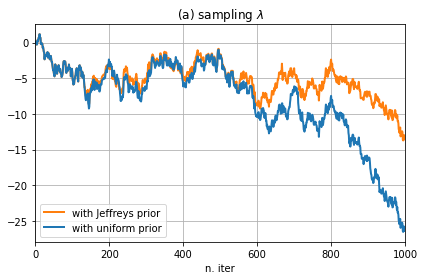

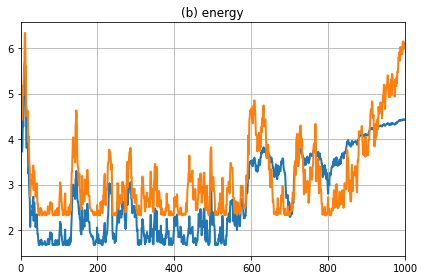

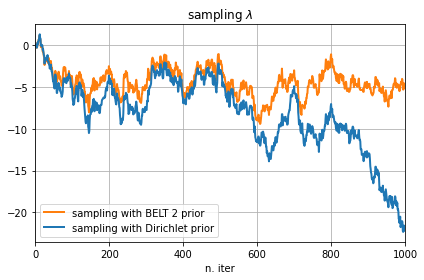

In [17]:
plt.rcParams['lines.linewidth'] = 2
# plt.rcParams.update({'figure.autolayout': True})

plt.figure(figsize=(6, 4))
plt.plot(outs['jeffreys'][0][:, 0], label='with Jeffreys prior', c='tab:orange')
plt.plot(outs['plain'][0][:, 0], label='with uniform prior', c='tab:blue')  # label=r'just $\mathcal{L}$')
# plt.ylabel(r'$\lambda$')
plt.title('(a) sampling $\lambda$')
plt.legend()
plt.grid()
plt.xlabel('n. iter')
plt.xlim([0, n_steps])
# plt.savefig('Manuscript_images/b_sampling_lambda2.pdf', format='pdf', bbox_inches='tight')


plt.figure(figsize=(6, 4))
plt.plot(outs['plain'][1])
plt.plot(outs['jeffreys'][1])
# plt.xlabel('n. iter')
plt.title('(b) energy')
# plt.ylabel('energy')
plt.grid()
plt.xlim([0, n_steps])
# plt.savefig('Manuscript_images/sampling_energy.pdf', format='pdf', bbox_inches='tight')

plt.figure(figsize=(6, 4))
plt.plot(outs['var'][0][:, 0], label='sampling with BELT 2 prior', c='tab:orange')
plt.plot(outs['dirichlet'][0][:, 0], label='sampling with Dirichlet prior', c='tab:blue')  # label=r'just $\mathcal{L}$')
# plt.ylabel(r'$\lambda$')
plt.title('sampling $\lambda$')
plt.legend()
plt.grid()
plt.xlabel('n. iter')
plt.xlim([0, n_steps])
# plt.savefig('Manuscript_images/c_sampling_lambda2.pdf', format='pdf', bbox_inches='tight')

Text(0.5, 0, '$\\mathcal{L}$')

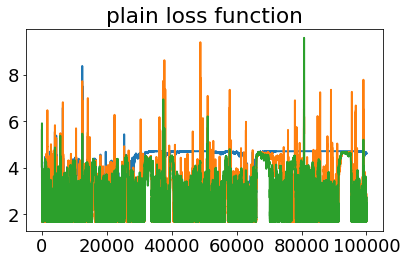

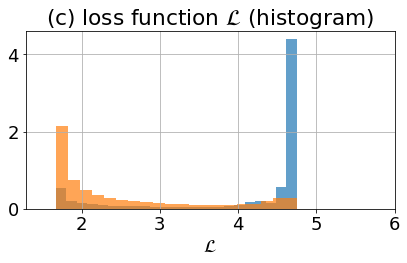

In [ ]:
plt.plot(outs['plain'][3][:, 2])
plt.plot(outs['jeffreys'][3][:, 2])
plt.plot(outs['dirichlet'][3][:, 2])
plt.title('plain loss function')

plt.figure(figsize=(6, 4))

# if you want to plat exp(-loss) rather than loss
# prob = np.exp([-x for x in np.array(out_noJ[3][:, 2])])
# probJ = np.exp([-x for x in np.array(out_J[3][:, 2])])

plt.hist(outs['plain'][3][:, 2], bins=50, label='plain sampling', alpha=0.7, density=True)
plt.hist(outs['jeffreys'][3][:, 2], bins=50, label='sampling with Jeffreys prior', alpha=0.7, density=True)
# plt.hist(outs['dirichlet'][3][:, 2], bins=50, label='sampling with Dirichlet prior', alpha=0.7, density=True)
plt.grid()
# plt.legend()
plt.title(r'(c) loss function $\mathcal{L}$ (histogram)')

xlims = plt.xlim()
plt.xlim([xlims[0], 6])

plt.xlabel(r'$\mathcal{L}$')

# plt.savefig('Manuscript_images/b_loss_hist.pdf', format='pdf', bbox_inches='tight')

posterior average of $\langle x \rangle_\lambda$:
w/o Jeffreys:  1.7668622766752538
with Jeffreys:  1.1771057940045617


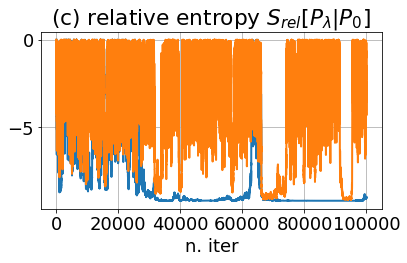

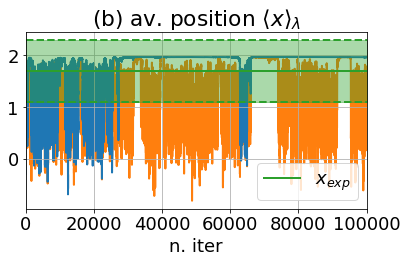

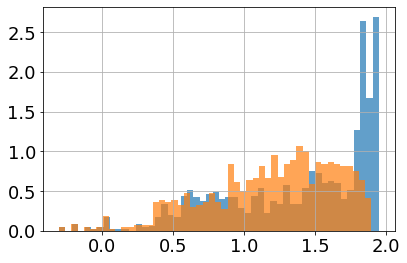

In [ ]:
# """ figure 1 """
plt.figure(figsize=(6, 4))
plt.plot(outs['plain'][3][:, 1])
plt.plot(outs['jeffreys'][3][:, 1])
plt.title(r'(c) relative entropy $S_{rel}[P_\lambda|P_0]$')
plt.xlabel('n. iter')
plt.grid()
# plt.savefig('Manuscript_images/sampling_Srel.pdf', format='pdf', bbox_inches='tight')

# """ figure 2 """
plt.figure(figsize=(6, 4))
plt.plot(outs['jeffreys'][3][:, 0], c='tab:orange', zorder=1)  # , alpha=0.7)
plt.plot(outs['plain'][3][:, 0], c='tab:blue', zorder=1)  # , alpha=0.7)

plt.plot([0, n_steps], [x_exp, x_exp], '-', label='$x_{exp}$', c='tab:green', zorder=2)
plt.plot([0, n_steps], [x_exp - sigma_exp, x_exp - sigma_exp], '--', c='tab:green', zorder=2)
plt.plot([0, n_steps], [x_exp + sigma_exp, x_exp + sigma_exp], '--', c='tab:green', zorder=2)
plt.fill_between([0, n_steps], [x_exp - sigma_exp, x_exp - sigma_exp], [x_exp + sigma_exp, x_exp + sigma_exp],
    alpha=0.4, color='tab:green', zorder=2)
plt.title(r'(b) av. position $\langle x \rangle_\lambda$')
plt.xlabel('n. iter')
plt.xlim([0, n_steps])
plt.grid()
plt.legend()
# plt.savefig('Manuscript_images/b_sampling_avx.pdf', format='pdf', bbox_inches='tight')

print(r'posterior average of $\langle x \rangle_\lambda$:')
print('w/o Jeffreys: ', np.mean(outs['plain'][3][:, 0]))
print('with Jeffreys: ', np.mean(outs['jeffreys'][3][:, 0]))

# """ figure 3 """
plt.figure(figsize=(6, 4))
plt.hist(outs['plain'][3][:, 0][:1000], bins=50, label='plain sampling', alpha=0.7, density=True)
plt.hist(outs['jeffreys'][3][:, 0][:1000], bins=50, label='sampling with Jeffreys prior', alpha=0.7, density=True)
plt.grid()
# plt.legend()

Text(0, 0.5, 'energy')

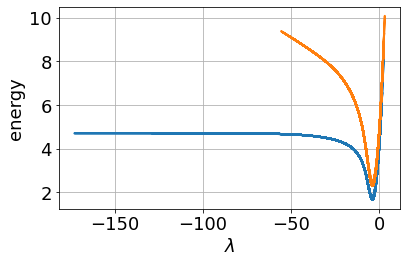

In [ ]:
plt.plot(outs['plain'][0][:, 0], outs['plain'][1])
plt.plot(outs['jeffreys'][0][:, 0], outs['jeffreys'][1])
plt.grid()
plt.xlabel(r'$\lambda$')
plt.ylabel('energy')

#### repeat over different seeds and plot the results for supplementary

In [ ]:
outs = {}

n_steps = int(1e5)
measures = ['plain', 'jeffreys', 'var', 'dirichlet']

for s in measures: outs[s] = []

seeds = np.arange(1, 7)  # the default seed (used for the images in the manuscript) is `seed = 2`

for seed in seeds:
    for measure in measures:
        energy_function = lambda x : energy_fun(x, measure)
        outs[measure].append(run_Metropolis(lambdas0, proposal_std, energy_function, n_steps=n_steps, seed=seed))
        outs[measure][-1][3][:, 0] = np.concatenate(outs[measure][-1][3][:, 0])


 95%|█████████▌| 95352/100000 [00:57<00:04, 1070.85it/s]/home/ivang/Documenti/my_github/Jeffreys_prior/Functions/basic_functions_bayesian.py:260: RuntimeWarning: invalid value encountered in sqrt
  self.std_g = np.sqrt(self.var_g)
100%|██████████| 100000/100000 [01:05<00:00, 1531.17it/s]
/home/ivang/Documenti/my_github/Jeffreys_prior/Functions/basic_functions_bayesian.py:529: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  else: return np.array(traj), np.array(ene), av_alpha, np.array(quantities)


100%|██████████| 100000/100000 [01:00<00:00, 1655.09it/s]


100%|██████████| 100000/100000 [01:03<00:00, 1568.64it/s]


100%|██████████| 100000/100000 [01:19<00:00, 1253.52it/s]


100%|██████████| 100000/100000 [00:57<00:00, 1750.35it/s]


100%|██████████| 100000/100000 [00:49<00:00, 2040.53it/s]


100%|██████████| 100000/100000 [00:51<00:00, 1944.82it/s]


100%|██████████| 100000/100000 [00:46<00:00, 2142.85it/s]


100%|██████████| 100000/100000 [00:47<00:00, 2089.70it/s]


100%|██████████| 100000/100000 [00:49<00:00, 2022.55it/s]


100%|██████████| 100000/100000 [00:51<00:00, 1946.31it/s]


100%|██████████| 100000/100000 [00:48<00:00, 2072.53it/s]


100%|██████████| 100000/100000 [00:44<00:00, 2267.67it/s]


100%|██████████| 100000/100000 [00:41<00:00, 2395.51it/s]


100%|██████████| 100000/100000 [00:41<00:00, 2386.15it/s]


100%|██████████| 100000/100000 [00:42<00:00, 2334.34it/s]


100%|██████████| 100000/100000 [00:50<00:00, 1981.50it/s]


100%|██████████| 100000/100000 [00:41<00:00, 2390.61it/s]


100%|██████████| 100000/100000 [00:42<00:00, 2367.24it/s]


100%|██████████| 100000/100000 [00:41<00:00, 2408.83it/s]


about 1000-2000 it/s

95%|█████████▌| 95352/100000 [00:57<00:04, 1070.85it/s]

In [ ]:
# from dict of lists to list of dicts (to plot)
outs = [dict(zip(outs.keys(), values)) for values in zip(*outs.values())]

In [ ]:
def plot_sampling(outs, if_first=True, if_last=True, saving_name=None):
    """
    if_first = True  # if if_first, it's the first line of plots so print titles and legends
    if_last = True  # if if_last, it's the last line of plots so print xlabels
    """

    plt.rcParams['lines.linewidth'] = 2
    plt.rcParams['font.size'] = 18
    plt.rcParams.update({'figure.autolayout': True})

    labels = ['plain', 'Jeffreys', 'av. g', 'Dirichlet']

    fig, axs = plt.subplots(1, 3, figsize=(15, 4))

    # SUBPLOT N. 0 : LAMBDA TRAJECTORIES
    for i, s in enumerate(outs.keys()): axs[0].plot(outs[s][0][:, 0], label=labels[i])  # , c='tab:orange')

    axs[0].set_ylabel(r'$\lambda$')

    if if_first:
        axs[0].set_title('(a) sampling $\lambda$')
    if if_last:
        axs[0].legend()
        axs[0].set_xlabel('n. iter')

    axs[0].grid()
    axs[0].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    axs[0].set_xlim([0, n_steps])

    # SUBPLOT N. 1 : AV. VALUES
    for s in outs.keys(): axs[1].plot(outs[s][3][:, 0], zorder=1, alpha=0.9)

    c = 'k'
    axs[1].plot([0, n_steps], [x_exp, x_exp], '-', label='$x_{exp}$', c=c, zorder=2)
    axs[1].plot([0, n_steps], [x_exp - sigma_exp, x_exp - sigma_exp], '--', c=c, zorder=2)
    axs[1].plot([0, n_steps], [x_exp + sigma_exp, x_exp + sigma_exp], '--', c=c, zorder=2)
    # axs[1].fill_between([0, n_steps], [x_exp - sigma_exp, x_exp - sigma_exp], [x_exp + sigma_exp, x_exp + sigma_exp],
    #     alpha=0.4, color=c, zorder=1)

    if if_first:
        axs[1].set_title(r'(b) av. position $\langle x \rangle_\lambda$')
    if if_last:
        axs[1].legend()
        axs[1].set_xlabel('n. iter')

    axs[1].set_ylabel(r'$\langle x \rangle_\lambda$')
    axs[1].set_xlim([0, n_steps])
    axs[1].ticklabel_format(axis='x', style='sci', scilimits=(0, 0))
    # axs[1].xaxis.get_offset_text().set_visible(True)
    axs[1].grid()

    # SUBPLOT N. 2 : HISTOGRAMS
    # plt.rcParams['lines.linewidth'] = 3
    for s in outs.keys(): axs[2].hist(outs[s][3][:, 2], bins=50, label=s, alpha=0.7, density=True)

    if if_first: axs[2].set_title(r'(c) loss function $\mathcal{L}$ (histogram)')
    if if_last: axs[2].set_xlabel(r'$\mathcal{L}$')

    xlims = axs[2].get_xlim()
    axs[2].set_xlim([xlims[0], 5])
    axs[2].grid()

    if saving_name is not None:
        plt.savefig(saving_name, format='pdf', bbox_inches='tight')


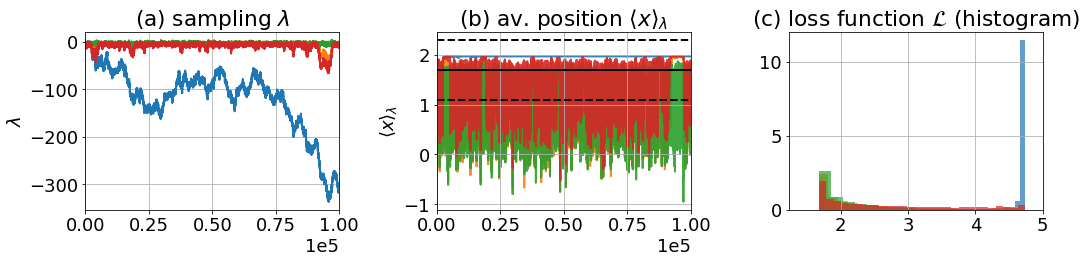

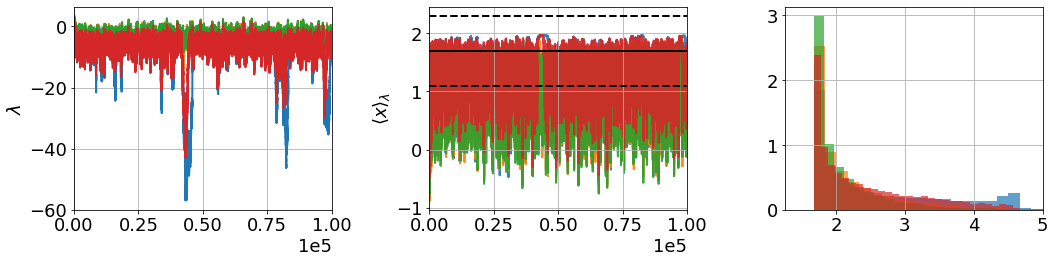

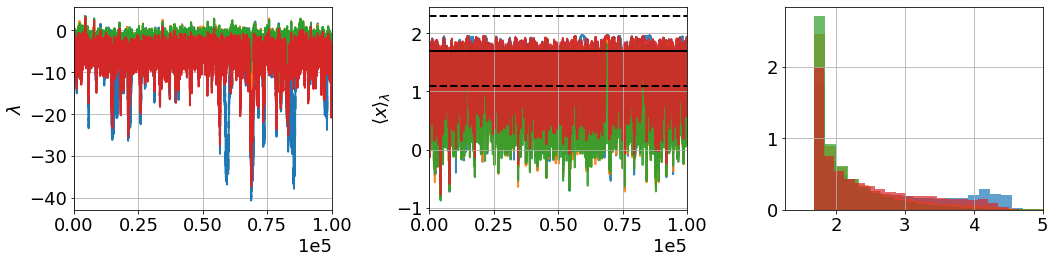

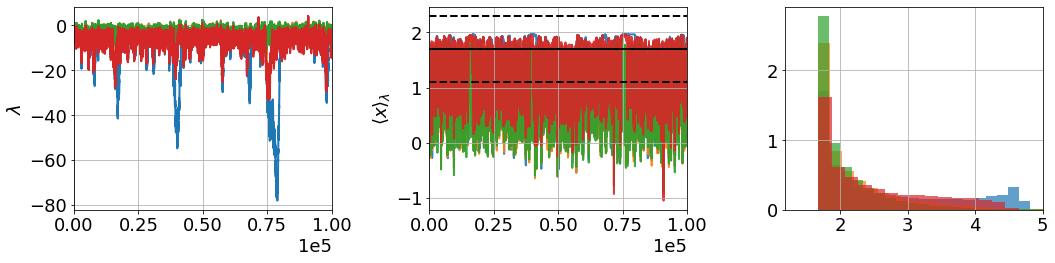

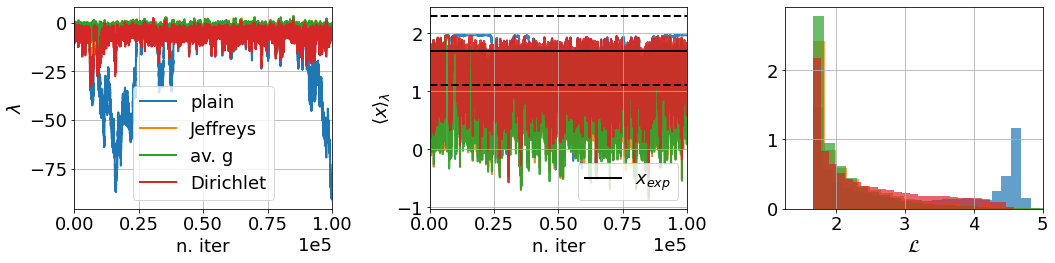

In [ ]:
for i in range(len(outs)):
    if_first = (i == 0)
    if_last = (i == len(outs) - 1)

    plot_sampling(outs[i], if_first, if_last, None)  # 'Manuscript_images/subplots_%i.pdf' % i)

### cycle over different strides and plot av. $D_{KL}$ vs. stride

In [ ]:
tot_n_frames = int(1e4)

measures = ['uniform', 'jeffreys', 'var', 'dirichlet']

strides = np.int64(10**np.arange(0, 3.5, 0.3))[1:]
print(strides)

outs = {}

seed = 1

for stride in strides:
    simple_model = Simple_model(tot_n_frames//stride, sigma, x_exp, sigma_exp, alpha, seed=seed)
    
    outs[stride] = {}
    
    for which_measure in ['uniform', 'jeffreys', 'var', 'dirichlet']:
        energy_function = lambda x : energy_fun(x, simple_model, which_measure)
        outs[stride][which_measure] = run_Metropolis(lambdas0, proposal_std, energy_function, n_steps=int(1e5), seed=seed)


[   1    3    7   15   31   63  125  251  501 1000 1995]


 95%|█████████▌| 95396/100000 [00:51<00:04, 1003.69it/s]/home/ivang/Documenti/my_github/Jeffreys_prior/Functions/basic_functions_bayesian.py:260: RuntimeWarning: invalid value encountered in sqrt
  self.std_g = np.sqrt(self.var_g)
100%|██████████| 100000/100000 [00:55<00:00, 1796.08it/s]
/home/ivang/Documenti/my_github/Jeffreys_prior/Functions/basic_functions_bayesian.py:529: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  av_alpha = av_alpha/n_steps


100%|██████████| 100000/100000 [00:47<00:00, 2110.42it/s]


100%|██████████| 100000/100000 [00:47<00:00, 2102.92it/s]


100%|██████████| 100000/100000 [00:48<00:00, 2055.23it/s]


100%|██████████| 100000/100000 [00:34<00:00, 2912.42it/s]


100%|██████████| 100000/100000 [00:32<00:00, 3066.20it/s]


100%|██████████| 100000/100000 [00:31<00:00, 3146.61it/s]


100%|██████████| 100000/100000 [00:33<00:00, 3001.22it/s]


100%|██████████| 100000/100000 [00:40<00:00, 2495.92it/s]


100%|██████████| 100000/100000 [00:24<00:00, 4024.53it/s]


100%|██████████| 100000/100000 [00:29<00:00, 3443.87it/s]


100%|██████████| 100000/100000 [00:26<00:00, 3710.52it/s]


100%|██████████| 100000/100000 [00:28<00:00, 3547.70it/s]


100%|██████████| 100000/100000 [00:22<00:00, 4406.48it/s]


100%|██████████| 100000/100000 [00:22<00:00, 4535.57it/s]


100%|██████████| 100000/100000 [00:31<00:00, 3194.11it/s]


100%|██████████| 100000/100000 [00:32<00:00, 3118.74it/s]


100%|██████████| 100000/100000 [00:26<00:00, 3783.95it/s]


100%|██████████| 100000/100000 [00:25<00:00, 3936.75it/s]


100%|██████████| 100000/100000 [00:26<00:00, 3707.16it/s]


100%|██████████| 100000/100000 [00:33<00:00, 2998.27it/s]


100%|██████████| 100000/100000 [00:20<00:00, 4770.65it/s]


100%|██████████| 100000/100000 [00:19<00:00, 5034.40it/s]


100%|██████████| 100000/100000 [00:21<00:00, 4731.87it/s]


100%|██████████| 100000/100000 [00:18<00:00, 5308.24it/s]


100%|██████████| 100000/100000 [00:18<00:00, 5310.32it/s]


100%|██████████| 100000/100000 [00:19<00:00, 5247.29it/s]


100%|██████████| 100000/100000 [00:19<00:00, 5098.65it/s]


100%|██████████| 100000/100000 [00:20<00:00, 4935.33it/s]


100%|██████████| 100000/100000 [00:19<00:00, 5222.29it/s]


100%|██████████| 100000/100000 [00:21<00:00, 4718.52it/s]


100%|██████████| 100000/100000 [00:23<00:00, 4344.09it/s]


100%|██████████| 100000/100000 [00:23<00:00, 4303.58it/s]


100%|██████████| 100000/100000 [00:22<00:00, 4393.46it/s]


100%|██████████| 100000/100000 [00:18<00:00, 5376.81it/s]


100%|██████████| 100000/100000 [00:18<00:00, 5461.27it/s]


100%|██████████| 100000/100000 [00:18<00:00, 5503.58it/s]


100%|██████████| 100000/100000 [00:21<00:00, 4589.08it/s]


100%|██████████| 100000/100000 [00:22<00:00, 4374.08it/s]


100%|██████████| 100000/100000 [00:19<00:00, 5083.56it/s]


100%|██████████| 100000/100000 [00:21<00:00, 4687.07it/s]


100%|██████████| 100000/100000 [00:23<00:00, 4184.10it/s]


100%|██████████| 100000/100000 [00:24<00:00, 4011.89it/s]


100%|██████████| 100000/100000 [00:24<00:00, 4065.08it/s]


In [ ]:
av_dkl = {}
std_dkl = {}

for s in measures:
    av_dkl[s] = {}
    std_dkl[s] = {}
    for stride in strides:
        av_dkl[s][stride] = -np.mean(outs[stride][s][3][:, 1])
        std_dkl[s][stride] = np.std(outs[stride][s][3][:, 1])

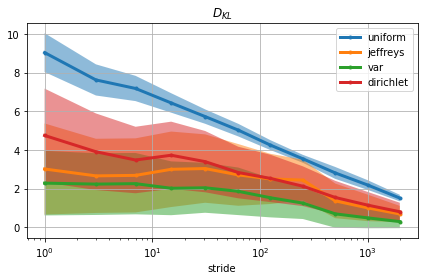

In [ ]:
for s in measures:
    av = np.array(list(av_dkl[s].values()))
    std = np.array(list(std_dkl[s].values()))
    plt.plot(av_dkl[s].keys(), av, '.-', label=s)
    plt.fill_between(av_dkl[s].keys(), av - std, av + std, alpha=0.5)
    

plt.xscale('log')
plt.xlabel('stride')
plt.title('$D_{KL}$')
plt.legend()
plt.grid()

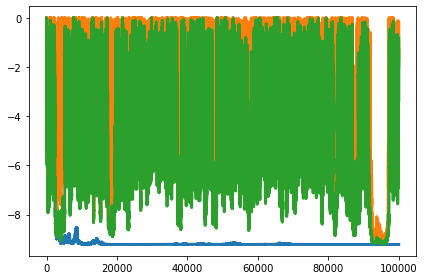

In [ ]:
plt.plot(outs[1]['uniform'][3][:, 1])
plt.plot(outs[1]['jeffreys'][3][:, 1])
plt.plot(outs[1]['dirichlet'][3][:, 1])

### Scaling

In [ ]:
from Functions.basic_functions_gaussian import numerical_props, analytical_props, flatten

In [ ]:
# alpha = 1.
# sigma = 0.1
# gexp = 0.3
# sigma_exp = 0.05

alpha = 0.5
sigma = 0.5
gexp = 1.7
sigma_exp = 0.6

#### Compute and save as pandas DataFrame (to txt)

In [ ]:
log_ns = np.linspace(1, 6, 10)
ns = np.unique(np.array([int(10**log_n) for log_n in log_ns]))

out1 = {}
out2 = {}

for n in ns:
    
    print(n)

    out1[n] = {}
    
    for m in range(5):
        out1[n][m] = numerical_props(n, sigma, gexp, sigma_exp, alpha, seed=m)
    
    out2[n] = analytical_props(n, sigma, gexp, sigma_exp, alpha, False)

10
35
129
464
1668
5994
21544
77426
278255
1000000


In [ ]:
df_th = pandas.DataFrame(out2).T
df_th.insert(0, 'n_frames', df_th.index)
df_th.index = range(df_th.shape[0])

""" inverf or logN """
# df_th.to_csv('Results/scaling_th_logN.txt')
# df_th.to_csv('Results/scaling_th_inverf.txt')

' inverf or logN '

In [ ]:
# save as pandas dataframe

df = pandas.DataFrame(out1[ns[0]]).loc[['min_lambda', 'min_loss', 'min_avg', 'gbar', 'lim_loss', 'lim_loss_num', 'lim_chi2', 'lim_dkl', 'dV']].T
df.insert(0, 'n_frames', ns[0])

for n in ns[1:]:
    df2 = pandas.DataFrame(out1[n]).loc[['min_lambda', 'min_loss', 'min_avg', 'gbar', 'lim_loss', 'lim_loss_num', 'lim_chi2', 'lim_dkl', 'dV']].T
    df2.insert(0, 'n_frames', n)
    df = pandas.concat([df, df2])

df.insert(0, 'seed', df.index)
df.index = range(df.shape[0])

j = 0  # 0 or 1

df['lim_loss'] = [df['lim_loss'].iloc[i][j][0] for i in range(len(df['lim_loss']))]

for s in ['lim_chi2', 'lim_loss_num', 'lim_dkl']:
    df[s] = [df[s].iloc[i][j] for i in range(len(df[s]))]

# df.to_csv('Results/scaling_num.txt')


#### Load pandas DataFrame from txt

In [ ]:
df = pandas.read_csv('Results/scaling_num.txt', sep=',', index_col=0)
df_th = pandas.read_csv('Results/scaling_th_inverf.txt', sep=',', index_col=0)

df

,seed,n_frames,min_lambda,min_loss,min_avg,gbar,lim_loss,lim_loss_num,lim_chi2,lim_dkl,dV
0,0,10,[-6.39080063],2.443498,[0.54961065],0.652000,2.676715,2.676713,3.050845,2.302582,0.233216
1,1,10,[-7.46408149],2.804361,[0.35627665],0.452678,3.312143,3.312141,4.321701,2.302582,0.507781
2,2,10,[-5.06069134],1.885737,[0.78902746],0.899854,2.040507,2.040505,1.778428,2.302582,0.154768
3,3,10,[-2.03511081],0.822125,[1.33369298],1.661500,1.153351,1.153365,0.004117,2.302612,0.331240
4,4,10,[-5.26137981],2.124384,[0.75255722],0.831862,2.198048,2.198046,2.093510,2.302582,0.073662
...,...,...,...,...,...,...,...,...,...,...,...
495,45,1000000,[-3.94007446],1.678560,[0.9877087],2.402050,7.592303,7.592323,1.369095,13.815552,5.913764
496,46,1000000,[-3.94744831],1.679855,[0.98634142],2.395659,7.579896,7.579917,1.344281,13.815552,5.900062
497,47,1000000,[-3.94751526],1.681565,[0.98650158],2.571905,7.963615,7.963635,2.111719,13.815552,6.282071
498,48,1000000,[-3.89088079],1.675994,[0.99629962],2.826322,8.669700,8.669721,3.523889,13.815552,6.993727


In [ ]:
def std_on_mean(x): return np.std(x)/np.sqrt(len(x))
cols = ['lim_chi2', 'lim_dkl', 'lim_loss', 'min_loss', 'dV']
df_pivot = pandas.pivot_table(df, values=cols, index=['n_frames'], aggfunc=['mean', 'std', 'first', std_on_mean])

df_pivot

mean                                                std  \
                dV  lim_chi2    lim_dkl  lim_loss  min_loss        dV   
n_frames                                                                
10        0.259580  2.794039   2.286621  2.548295  2.280750  0.137515   
35        0.517079  1.447995   3.541044  2.501641  1.977441  0.138964   
129       0.912872  0.669440   4.835663  2.764598  1.839680  0.123444   
464       1.410478  0.181974   6.104734  3.160895  1.732876  0.080577   
1668      2.025001  0.072564   7.404551  3.745972  1.713556  0.079000   
5994      2.721969  0.122438   8.691446  4.410477  1.684973  0.128417   
21544     3.464785  0.361797   9.934321  5.169846  1.683274  0.212714   
77426     4.292295  0.705763  11.241237  5.981426  1.681205  0.236528   
278255    5.098230  1.039695  12.517774  6.788032  1.680504  0.198621   
1000000   5.978813  1.535992  13.783340  7.675823  1.680852  0.294827   

                                                     first            \
          lim_chi2   lim_dkl  lim_loss  min_loss        dV  lim_chi2   
n_frames                                                               
10        1.359384  0.098605  0.679681  0.678068  0.233216  3.050845   
35        0.864345  0.090711  0.432127  0.415824  0.596433  2.871716   
129       0.388998  0.120772  0.194446  0.191264  1.138857  1.356465   
464       0.212064  0.133149  0.105958  0.117533  1.372895  0.077452   
1668      0.076541  0.096560  0.038268  0.063003  1.981757  0.077452   
5994      0.205136  0.034458  0.102567  0.038644  2.630823  0.014161   
21544     0.352735  0.149280  0.176354  0.017799  3.393108  0.206683   
77426     0.445610  0.097979  0.222802  0.010506  4.572327  1.232022   
278255    0.373832  0.079561  0.186904  0.006048  5.206241  1.232022   
1000000   0.559760  0.110569  0.279848  0.003706  5.845004  1.232022   

                                        std_on_mean                      \
            lim_dkl  lim_loss  min_loss          dV  lim_chi2   lim_dkl   
n_frames                                                                  
10         2.302582  2.676715  2.443498    0.019252  0.190314  0.013805   
35         3.555359  3.213532  2.617104    0.019455  0.121008  0.012700   
129        4.859558  3.108138  1.969154    0.017282  0.054460  0.016908   
464        6.139893  3.108668  1.735778    0.011281  0.029689  0.018641   
1668       7.419373  3.748416  1.766656    0.011060  0.010716  0.013518   
5994       8.698486  4.356338  1.725501    0.017978  0.028719  0.004824   
21544      9.977661  5.092268  1.699064    0.029780  0.049383  0.020899   
77426     11.257080  6.244550  1.672225    0.033114  0.062385  0.013717   
278255    12.536255  6.884157  1.677898    0.027807  0.052336  0.011139   
1000000   13.815552  7.523766  1.678783    0.041276  0.078366  0.015480   

                              
          lim_loss  min_loss  
n_frames                      
10        0.095155  0.094930  
35        0.060498  0.058215  
129       0.027222  0.026777  
464       0.014834  0.016455  
1668      0.005358  0.008820  
5994      0.014359  0.005410  
21544     0.024690  0.002492  
77426     0.031192  0.001471  
278255    0.026167  0.000847  
1000000   0.039179  0.000519

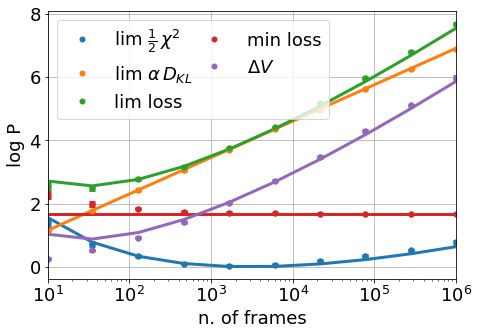

In [ ]:
j = 0  # 0 or 1, depending on max/min g

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markeredgewidth'] = 3
plt.rcParams['font.size'] = 18
plt.rcParams.update({'figure.autolayout': True})

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']  # ,'tab:brown','tab:pink',
          #   'tab:gray','tab:olive','tab:cyan']

plt.figure(figsize=(7, 5))

plt.plot(ns, 1/2*df_pivot['mean']['lim_chi2'], '.', label=r'lim $\frac{1}{2} \, \chi^2$', c=colors[0])
plt.errorbar(ns, 1/2*df_pivot['mean']['lim_chi2'], 1/2*df_pivot['std_on_mean']['lim_chi2'], c=colors[0], fmt='.', capsize=3)
plt.plot(ns, 1/2*df_th['lim_chi2'], c=colors[0])

# overestimate of the chi2 with sqrt(log(n))
# plt.plot(ns, 1/2*((sigma*np.sqrt(2*np.log(ns)) - gexp)/sigma_exp)**2, label='1/2 chi2 est')

plt.plot(ns, alpha*df_pivot['mean']['lim_dkl'], '.', label=r'lim $\alpha\,D_{KL}$', c=colors[1])
plt.errorbar(ns, alpha*df_pivot['mean']['lim_dkl'], alpha*df_pivot['std_on_mean']['lim_dkl'], c=colors[1], fmt='.', capsize=3)
plt.plot(ns, alpha*df_th['lim_dkl'], c=colors[1])

plt.plot(ns, df_pivot['mean']['lim_loss'], '.', label='lim loss', c=colors[2])
plt.errorbar(ns, df_pivot['mean']['lim_loss'], df_pivot['std_on_mean']['lim_loss'], c=colors[2], fmt='.', capsize=3)
plt.plot(ns, df_th['lim_loss'], c=colors[2])

plt.plot(ns, df_pivot['mean']['min_loss'], '.', label='min loss', c=colors[3])
plt.errorbar(ns, df_pivot['mean']['min_loss'], df_pivot['std_on_mean']['min_loss'], c=colors[3], fmt='.', capsize=3)
plt.plot(ns, df_th['min_loss'], c=colors[3])

plt.plot(ns, df_pivot['mean']['dV'], '.', label='$\Delta V$', c=colors[4])
plt.errorbar(ns, df_pivot['mean']['dV'], df_pivot['std_on_mean']['dV'], c=colors[4], fmt='.', capsize=3)
plt.plot(ns, df_th['dV'], c=colors[4])

plt.grid()
plt.xscale('log')
plt.xlabel('n. of frames')
# plt.yscale('log')
plt.legend(ncol=2, columnspacing=0.2)
plt.xlim([ns[0], ns[-1]])
plt.ylabel('log P')

# plt.savefig('Manuscript_images/ex3_scaling_inverf.pdf', format='pdf', bbox_inches='tight')

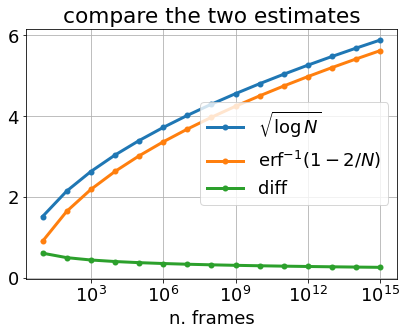

In [ ]:
ns = np.array([10, 100, 1000, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9, 1e10, 1e11, 1e12, 1e13, 1e14, 1e15])

from scipy.special import erfinv

est1 = np.sqrt(np.log(ns))
est2 = erfinv(1 - 2/ns)

plt.figure(figsize=(6, 5))
plt.title('compare the two estimates')
plt.plot(ns, est1, '.-', label=r'$\sqrt{\log N}$')
plt.plot(ns, est2, '.-', label=r'$\mathrm{erf}^{-1}(1 - 2/N)$')
plt.plot(ns, est1 - est2, '.-', label='diff')
plt.xscale('log')
plt.xlabel('n. frames')
plt.legend()
plt.grid()
